Rolling Predictive Neural Network
---

---

The idea of the Rolling Neural Network is to train the model by followig the temporal structure of the data. By exemple we start to train over 1 year (from 01/01/2000 to 31/12/2000), predict 3 months ahead (from 01/01/2001 to 31/03/2001), and move 3 months ahead to retrain the model (from 01/04/2000 to 31/03/2001) and predict again 3 months ahead (from 01/04/2001 to 30/06/2001), and so on until present.

---

In this exemple I used most basic Keras neural network that I rolled over temporal axis to predict the sign of SP500 one day ahead. 
Data used are only past data from SP500 that I transform with several methods (moving average, financial indicators, etc.). 

In [1]:
# Import extern packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from jupyterthemes import jtplot
from IPython.display import clear_output
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers, initializers, constraints
from keras import backend as K

# Import local packages
import fynance as fy
from Core.ML_tools import set_nn_model, display_perf
from Core.roll_multi_neural_network import RollMultiNeuralNet

Using TensorFlow backend.


In [2]:
def sign(X, alpha=0.05):
    inf_alpha = np.abs(X) < alpha
    not_inf_alpha = np.abs(X) >= alpha
    X[inf_alpha] = 0.
    X[not_inf_alpha] = np.sign(X[not_inf_alpha])
    return X

---

Load Data (SP500)
---

In [3]:
path = '/home/arthur/GitHub/ML_Finance/Data/daily_finance_data.xlsx'
sheet_name = 'Sheet4' # 'Sheet5'
UNDERLY = 'SP500' # '5US' # 'NIKKEI' # 

df = pd.read_excel(path, sheet_name=sheet_name).set_index('Date')
df = df.loc[:, [UNDERLY]].dropna()

axis_date = df.index.values[1:]

---

Set Target
---

In [4]:
""" Y is the sign of log returns from 1 to T """
I = np.log(df.values)
lr = I[1:] - I[: -1]
alpha = 0.
y = lr.flatten() #sign_std_out(lr.flatten(), alpha=alpha)
y = y.reshape([y.size, 1])

y.flatten()

array([-0.002567  , -0.00821183, -0.00978543, ..., -0.01381784,
        0.00220059,  0.        ])

---

Set Features (Transfo Data)
---

In [5]:
""" X is set with data from 0 to T - 1 """

# THIS PART OF SCRIPT IS NOT AVAILABLE

array([[-0.0325155 , -0.04735096, -0.05950896, ..., -1.44674652,
        -0.41448773, -1.62059504],
       [-0.26832455, -0.04735096, -0.05950896, ..., -1.44790692,
        -1.18041106, -1.62131933],
       [-0.78686971, -0.76826731, -0.05950896, ..., -1.10830123,
        -1.4688911 , -1.40934869],
       ...,
       [ 0.14098114, -0.34031135, -0.20875848, ..., -0.52488295,
         0.42859557, -0.3498435 ],
       [-1.30184792, -0.84520517, -1.07641286, ..., -0.52479362,
        -0.09962433, -0.38281372],
       [ 0.1696345 , -0.82434329, -0.60314035, ..., -0.53685841,
        -0.03418088, -0.39588859]])

---

Set Neural Network Model
---

RollNeuralNet Strategy on SP500
---

---

I use a function that I don't display to set parameters of my neural network model but it's a very basic and simple neural network.

In [29]:
models = []
for i in range(1):
    model = set_nn_model(
        X, SEED=None, activation='tanh'
    )
    models += [model]

Let run RollNeuralNetwork Strategy on SP500 !


<IPython.core.display.Javascript object>


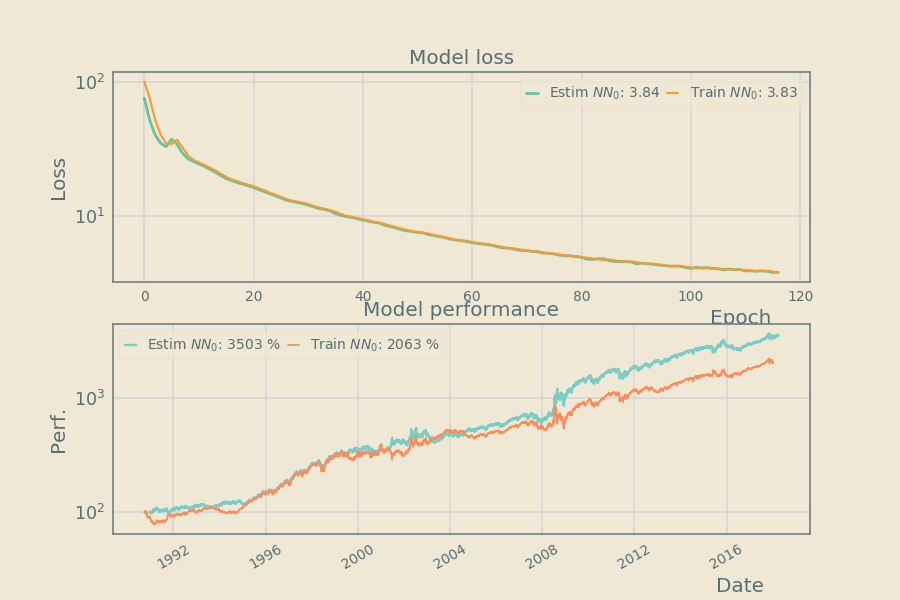

+=============================+
|          Accuracy           |
+----------------+------------+
| Strategy       |     51.28% |
| Strat_IsoVol   |     51.28% |
+=============================+
|         Performance         |
+----------------+------------+
| SP500          |      9.80% |
| Strategy       |     13.28% |
| Strat_IsoVol   |     18.76% |
+=============================+
|          Volatility         |
+----------------+------------+
| SP500          |     17.35% |
| Strategy       |     17.30% |
| Strat_IsoVol   |     20.99% |
+=============================+
|         Sharpe Ratio        |
+----------------+------------+
| SP500          |       0.56 |
| Strategy       |       0.77 |
| Strat_IsoVol   |       0.89 |
+=============================+
|         Calmar Ratio        |
+----------------+------------+
| SP500          |       0.18 |
| Strategy       |       0.46 |
| Strat_IsoVol   |       0.67 |
+=============================+



<IPython.core.display.Javascript object>


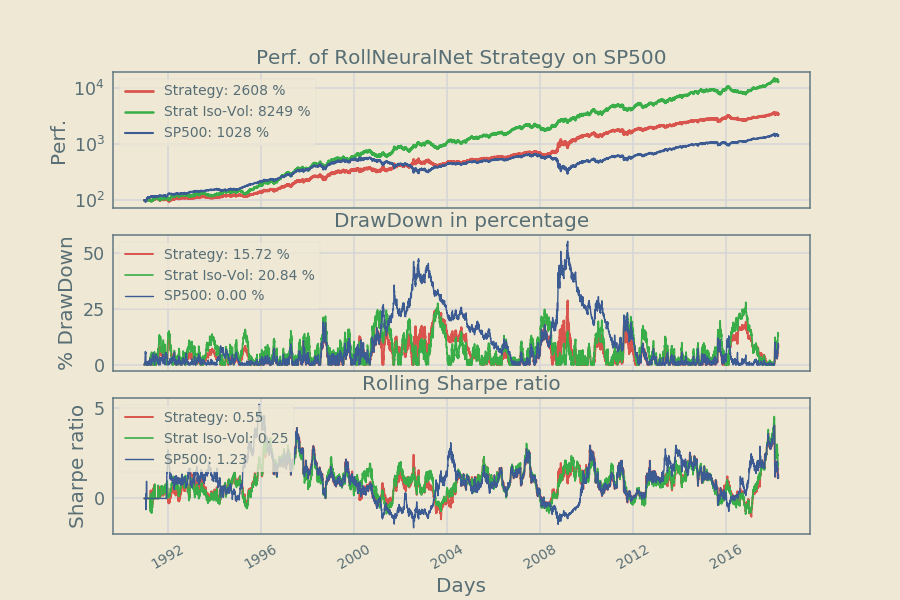

In [30]:
%matplotlib notebook

# Set variables: Train on one year and predict on three months
n = 63 * 4 
s = 21 * 3
params = {'batch_size': s, 'epochs': 1, 'shuffle': False, 'verbose': 0}
init_params = {'batch_size': n, 'epochs': 5, 'shuffle': False, 'verbose': 0}

# Train model
print("Let run RollNeuralNetwork Strategy on {} !".format(UNDERLY))
print("======================================{}==".format('=' * len(UNDERLY)))
rmnn = RollMultiNeuralNet(
    train_period=n, estim_period=s, params=params, init_params=init_params
)
rmnn = rmnn.run(y=y, X=X, NN=models, x_axis=axis_date)

# Results
y_estim = np.mean(np.sign(rmnn.y_estim.copy()), axis=1)
# Plot perf. on estimating set
perf_idx, perf_est, perf_ivo = display_perf(
    y[n: - s, 0], sign(y_estim[n: - s].copy(), alpha=0.1), period=252, 
    title='Perf. of RollNeuralNet Strategy on {}'.format(UNDERLY),
    params_iv={'leverage': 2., 'half_life': 5}, 
    x_axis=axis_date[n: -s], underlying=UNDERLY,
)

RollMultiNeuralNet Strategy on SP500
---

---

Train simultanously several (five here) rolling neural network and aggregate results.

In [36]:
models = []
for i in range(5):
    model = set_nn_model(
        X, SEED=None, l1=0.02, l2=0.02, dropout=0.05, 
        activation='tanh', lr=0.08, b_1=0.99, b_2=0.999
    )
    models += [model]

Let run RollNeuralNetwork Strategy on SP500 !


<IPython.core.display.Javascript object>


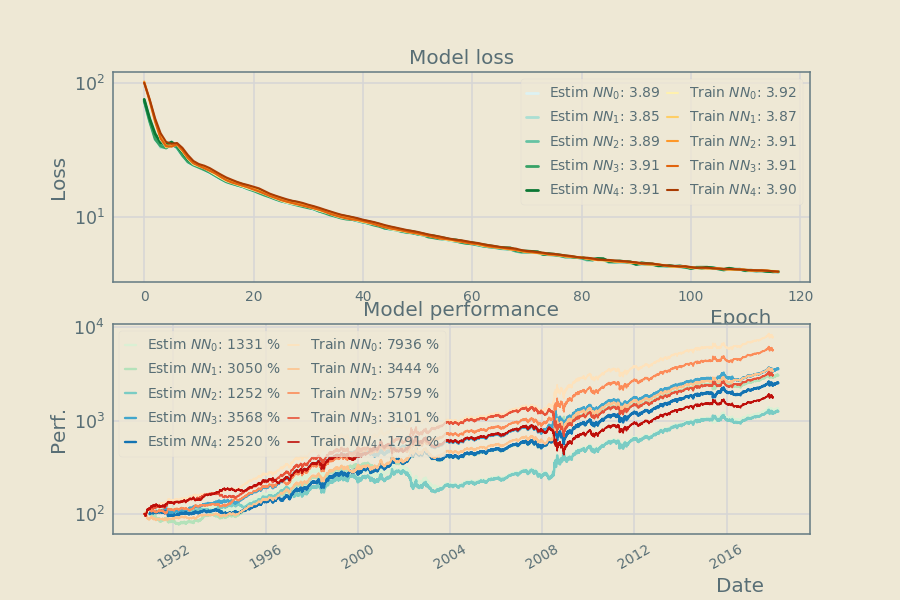

+=============================+
|          Accuracy           |
+----------------+------------+
| Strategy       |     46.91% |
| Strat_IsoVol   |     46.91% |
+=============================+
|         Performance         |
+----------------+------------+
| SP500          |      9.80% |
| Strategy       |     12.11% |
| Strat_IsoVol   |     19.01% |
+=============================+
|          Volatility         |
+----------------+------------+
| SP500          |     17.35% |
| Strategy       |     15.51% |
| Strat_IsoVol   |     19.77% |
+=============================+
|         Sharpe Ratio        |
+----------------+------------+
| SP500          |       0.56 |
| Strategy       |       0.78 |
| Strat_IsoVol   |       0.96 |
+=============================+
|         Calmar Ratio        |
+----------------+------------+
| SP500          |       0.18 |
| Strategy       |       0.45 |
| Strat_IsoVol   |       0.68 |
+=============================+



<IPython.core.display.Javascript object>


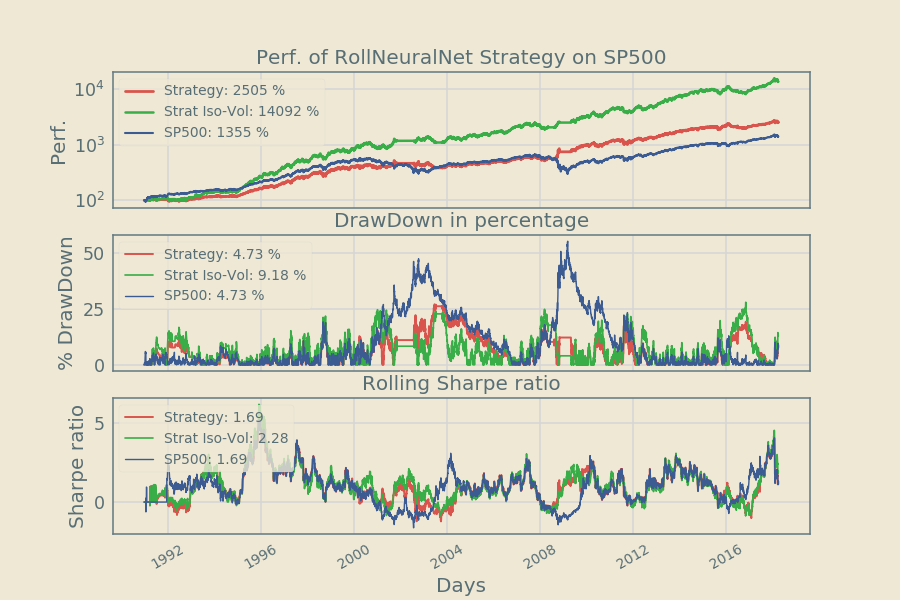

<IPython.core.display.Javascript object>


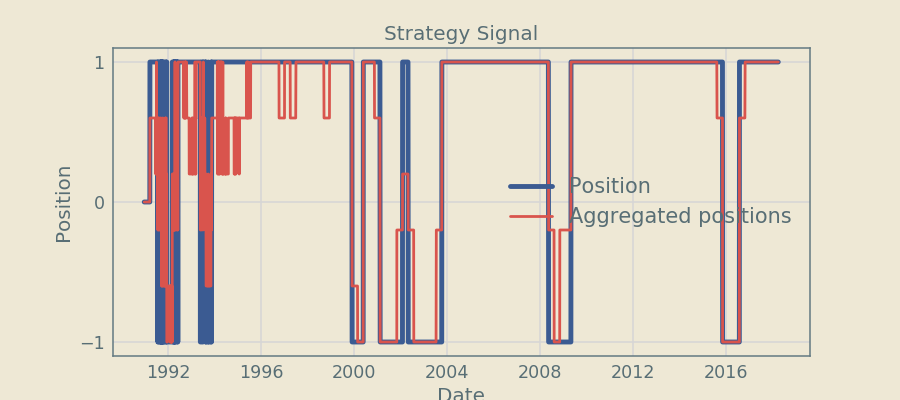

In [37]:
%matplotlib notebook

# Set variables
n = 63 * 4
s = 21 * 3
params = {'batch_size': s, 'epochs': 1, 'shuffle': False, 'verbose': 0}
init_params = {'batch_size': n, 'epochs': 5, 'shuffle': False, 'verbose': 0}

# Train model
print("Let run RollNeuralNetwork Strategy on {} !".format(UNDERLY))
print("======================================{}==".format('=' * len(UNDERLY)))
rmnn = RollMultiNeuralNet(
    train_period=n, estim_period=s, params=params, init_params=init_params
)
rmnn = rmnn.run(y=y, X=X, NN=models, x_axis=axis_date)

# AGGREGATION
y_estim = np.mean(np.sign(rmnn.y_estim.copy()), axis=1)
# Plot perf. on estimating set
perf_idx, perf_est, perf_ivo = display_perf(
    y[n: - s, 0], sign(y_estim[n: - s].copy(), alpha=0.3), period=252, 
    title='Perf. of RollNeuralNet Strategy on {}'.format(UNDERLY),
    params_iv={'leverage': 2., 'half_life': 5}, 
    x_axis=axis_date[n: -s], underlying=UNDERLY,
)

# Plot signal
f, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(
    axis_date[n: -s], 
    sign(y_estim[n: - s].copy(), alpha=0.1), 
    color=sns.xkcd_rgb["denim blue"], 
    LineWidth=3.5
)
ax.plot(
    axis_date[n: -s], 
    y_estim[n: -s], 
    color=sns.xkcd_rgb["pale red"], 
    LineWidth=2.
)
ax.set_yticks([-1, 0, 1])
ax.set_title('Strategy Signal')
ax.legend(['Position', 'Aggregated positions'], fontsize=15)
ax.set_xlabel('Date')
ax.set_ylabel('Position')
plt.show()